In [2]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Motivation

World-class methods for image classification can be found [here](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

# Download Data

In [4]:
PATH = '/usr/local/data/digit-recognizer'
#!kaggle competitions download -c digit-recognizer -p {PATH}

train_labels, train = [x.squeeze() for x in np.hsplit(pd.read_csv('{}/train.csv'.format(PATH)).values, [1])]
test = pd.read_csv('{}/test.csv'.format(PATH)).values

# Explore Data

In [5]:
def reshape(arr, width=28, height=28):
    return np.uint8(arr.reshape(width, height))

def show(arr):
    plt.imshow(reshape(arr), cmap=matplotlib.cm.binary, interpolation='nearest')

## Data Layout

MNIST images are 28x28 8-bit arrays stored as a single length 784 array.

In [6]:
print(train.shape)
print(train.min(), train.max())

(42000, 784)
0 255


In [7]:
np.set_printoptions(linewidth=100)
reshape(train[0])

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 188, 255,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 191, 250, 253,  93,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

## Images

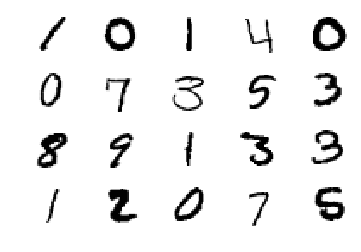

In [8]:
for i in range(0, 20):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(train[i].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest') 

# Submission Baseline

## All Zero

In [9]:
message = 'all zeros'
predictions=0

#test.assign(Label=predictions).to_csv('{}/submissions/{}.csv'.format(PATH, message), columns=['Label'], float_format='%.f')
#!kaggle competitions submit -c digit-recognizer -f "{PATH}/submissions/{message}.csv" -m "{message}"

# Prepare Data

## Augment

Add generated images to the data set.

Transformations include:
- shift left/right/up/down
- rotate left/right
- stretch horizontal/vertical
- scale up/down

Each augmentation chooses small values for changing the angle, position, and scale of the original image. The resulting transformations should then be unique, but similar enough to the original image to retain the orginal label. Typically 3-5 augmented images are added to the original, boosting the training set size significantly.

In [9]:
from PIL import Image
from scipy import stats

def transform(imarray, w=None, h=None, angle=0, dx=0, dy=0, dw=0, dh=0):
    im = Image.fromarray(reshape(imarray))
    size = (w or im.width, h or im.height)
    resized = im.resize(size, Image.BICUBIC, (dw, dh, im.width - dw, im.height - dh))
    rotated = resized.rotate(angle, Image.BICUBIC, translate=(dx, dy))
    data = rotated.getdata()
    return np.array(data)

def augment(X, num_augmentations=3, reshape=False):
    da = stats.randint(-10, 11).rvs
    dxy = stats.randint(-2, 3).rvs
    dwh = stats.randint(0, 3).rvs
    transformations = np.apply_along_axis(lambda x: [transform(x, angle=da(), dx=dxy(), dy=dxy(), dw=dwh(), dh=dwh()) for i in range(0, num_augmentations)], 1, X)
    concatenated = np.concatenate([np.expand_dims(X, axis=1), transformations], axis=1)
    return concatenated.reshape(-1, X.shape[1]) if reshape else concatenated

In [10]:
num_augmentations = 1
train = augment(train, num_augmentations, True)
train_labels = np.repeat(train_labels, num_augmentations + 1)

## Explore Augmented Data

In [11]:
print(train.shape, train_labels.shape)

(84000, 784) (84000,)


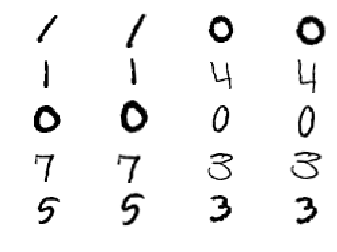

In [12]:
for i in range(0, 20):
    plt.subplot(5, 4, i + 1)
    plt.axis('off')
    plt.imshow(train[i].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest') 

In [13]:
train_labels[:20]

array([1, 1, 0, 0, 1, 1, 4, 4, 0, 0, 0, 0, 7, 7, 3, 3, 5, 5, 3, 3])

## Shuffle

In [10]:
train, train_labels = sklearn.utils.shuffle(train, train_labels)

## Transform

In [11]:
from sklearn.pipeline import Pipeline
from ml.transformers import ConstantScaler

pipeline = Pipeline([
    ('scale', ConstantScaler(1.0/255)),
])

train_prepared = pipeline.fit_transform(train)

# Model Selection

In [12]:
# TODO: move functions to /usr/local/lib/ml/util

from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

def evaluate_model(estimator, X, y=None, cv=5, scoring='accuracy'):
    scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)['test_score']
    return estimator.__class__.__name__, scores.mean(), scores.std()

def rank_models(estimators, X, y=None, cv=5, scoring='accuracy'):
    scores = [evaluate_model(estimator, X, y, cv, scoring) for estimator in estimators]
    columns= ['Model', 'Mean', 'Std Dev']
    return pd.DataFrame(scores, columns=columns).set_index('Model')

estimators = tqdm([
#    AdaBoostClassifier(),
#    DummyClassifier(),
#    ExtraTreesClassifier(),
#    GradientBoostingClassifier(),
    KNeighborsClassifier(),
#    LinearSVC(),
#    NearestCentroid(),
    RandomForestClassifier(),
#    RidgeClassifier(),
#    SVC(),
    XGBClassifier()
])
scores = rank_models(estimators, train_prepared[:5000], train_labels[:5000], cv=3)
scores.sort_values('Mean', ascending=False)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

,Mean,Std Dev
Model,,
KNeighborsClassifier,0.915405,0.005033
XGBClassifier,0.906798,0.008260
RandomForestClassifier,0.861998,0.006963


KNeighborsClassifier is both highly accurate and fast to train.  The boosting models are also quite accurate but take so long to train that proper hyperparameter search will be impossible.

# Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def grid_search(estimator, distribution, X, y, n_results=3):
    search = GridSearchCV(estimator(), distribution, n_jobs=-1, return_train_score=False, verbose=1)
    results = search.fit(X, y).cv_results_
    indexes = np.argsort(results['rank_test_score'])[:n_results]
    params = np.array(results['params'])[indexes]
    return params
    
def randomized_search(estimator, distribution, X, y, n_iter=1000, n_results=3):
    search = RandomizedSearchCV(estimator(), distribution, n_iter=n_iter, n_jobs=-1, return_train_score=False, verbose=1)
    results = search.fit(X, y).cv_results_
    indexes = np.argsort(results['rank_test_score'])[:n_results]
    params = np.array(results['params'])[indexes]
    return params

hyperparameter_distributions = {
    KNeighborsClassifier: {
        'n_neighbors': [1, 3, 5, 7, 9, 11],
        'weights': ['distance'],
        'algorithm': ['ball_tree'],
        'leaf_size': [10, 20, 30, 45, 60, 75, 100],
        'p': [2]
    }
}
    
hyperparameters = {
    estimator: grid_search(estimator, distribution, train_prepared[:5000], train_labels[:5000], n_results=1)
    for estimator, distribution in hyperparameter_distributions.items()
    if estimator in [KNeighborsClassifier]
}
hyperparameters

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  3.0min finished


{sklearn.neighbors.classification.KNeighborsClassifier: array([{'algorithm': 'ball_tree', 'leaf_size': 45, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}],
       dtype=object)}

In [16]:
from sklearn.neighbors import KNeighborsClassifier

hyperparameters = {
    KNeighborsClassifier: np.array([{
        'algorithm': 'ball_tree',
        'leaf_size': 10,
        'n_neighbors': 3,
        'p': 2,
        'weights': 'distance'
    }])
}
hyperparameters

{sklearn.neighbors.classification.KNeighborsClassifier: array([{'algorithm': 'ball_tree', 'leaf_size': 75, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}],
       dtype=object)}

# Model Ensemble

In [19]:
from sklearn.ensemble import VotingClassifier

voting_estimators = [
    ('{}-{}'.format(estimator.__name__, i), estimator(**param))
    for estimator, params in hyperparameters.items()
    for i, param in enumerate(params)
]
voting_classifier = VotingClassifier(voting_estimators, voting='soft')
evaluate_model(voting_classifier, train_prepared[:5000], train_labels[:5000])

# Test Time Augmentation

In [37]:
def TTA(model, X, num_augmentations=4, split_size=1000):
    predictions = []
    for arr in tqdm(np.array_split(X, np.size(X, 0) / split_size)):
        prepared = pipeline.transform(augment(arr, num_augmentations, True))
        probs = model.predict_proba(prepared).reshape(-1, num_augmentations + 1, 10).mean(axis=1)
        predictions.append(np.argmax(probs, axis=1))
    return np.hstack(predictions)

# Prediction

In [21]:
final_estimator = voting_classifier
final_estimator.fit(train_prepared, train_labels)

VotingClassifier(estimators=[('KNeighborsClassifier-0', KNeighborsClassifier(algorithm='ball_tree', leaf_size=75, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [ ]:
use_tta = True

if use_tta:
    final_predictions = final_estimator.predict(pipeline.transform(test))
else:    
    final_predictions = TTA(final_estimator, test, 4, 100)

print(final_predictions.shape, final_predictions[:20])

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

# Submission

In [28]:
# TODO: put in /usr/local/lib/ml/util
# TODO: refactor download and baseline submission cells to use utility functions

def download(competition, path):
    !kaggle competitions download -c "{competition}" -p "{path}"

def submit(competition, file, message):
    !kaggle competitions submit -c "{competition}" -f "{file}" -m "{message}"

In [26]:
final_indices = np.arange(1, final_predictions.size + 1)
final_csv = '{}/submissions/tuned_large_knn_with_tta.csv'.format(PATH)
np.savetxt(final_csv, np.array([final_indices, final_predictions]).transpose(), fmt='%d', header='ImageId,Label', comments='', delimiter=',')

In [29]:
submit('digit-recognizer', final_csv, 'tuned knn on full training set with training and test set augmentation')

Successfully submitted to Digit Recognizer